# Reducción de Ruido con Non-Local Means (NLM)
Este notebook demuestra la aplicación del algoritmo **Non-Local Means (NLM)** para la eliminación de ruido en imágenes.

En el framework VCF, este filtro se aplica durante la etapa de **decodificación**.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import display, Image
import sys
sys.path.append('../src')
from visualization import show_results_nlm


## Método: Non-Local Means (NLM)
El filtro **NLM** promedia píxeles basándose en la similitud de regiones (patches) en lugar de solo en la proximidad física. Esto permite una excelente conservación de bordes.

**Parámetros disponibles:**
- `-h` o `--h`: **Fuerza del filtro**. Determina cuánto ruido se elimina. Valores recomendados: 5 a 30.
- `-t` o `--template_window_size`: **Tamaño del parche de plantilla**. Es el tamaño del bloque que se usa para comparar similitudes (debe ser impar, por defecto 7).
- `-s` o `--search_window_size`: **Tamaño del área de búsqueda**. Es la zona donde se buscan parches similares (debe ser impar, por defecto 21).

--- 
## Caso 1: Imagen `ruido.jpg`

In [2]:
# 1. Codificar imagen original
!python ../src/no_filter.py encode -i ../img/ruido.jpg -e ../img/ruido_encoded

# 2. Decodificar aplicando NLM (h=5, 15, 30)
!python ../src/NLM.py decode -i ../img/ruido_encoded.tif -o ../img/nlm_h5.png --h 5
!python ../src/NLM.py decode -i ../img/ruido_encoded.tif -o ../img/nlm_h15.png --h 15
!python ../src/NLM.py decode -i ../img/ruido_encoded.tif -o ../img/nlm_h30.png --h 30

main Namespace(debug=False, subparser_name='encode', entropy_image_codec='TIFF', original='../img/ruido.jpg', encoded='../img/ruido_encoded', func=<function encode at 0x000001E27C65F920>)


(INFO) entropy_image_coding: Written 1052877 bytes in ../img/ruido_encoded.tif


main Namespace(debug=False, subparser_name='decode', h=5.0, template_window_size=7, search_window_size=21, entropy_image_codec='TIFF', encoded='../img/ruido_encoded.tif', decoded='../img/nlm_h5.png', func=<function decode at 0x00000286E6596660>)


(INFO) NLM: NLM filter strength (h)=5.0
(INFO) NLM: NLM template window size=7
(INFO) NLM: NLM search window size=21
(INFO) NLM: Aplicando denoising NLM a imagen en color


main Namespace(debug=False, subparser_name='decode', h=15.0, template_window_size=7, search_window_size=21, entropy_image_codec='TIFF', encoded='../img/ruido_encoded.tif', decoded='../img/nlm_h15.png', func=<function decode at 0x000002501DC76660>)


(INFO) NLM: NLM filter strength (h)=15.0
(INFO) NLM: NLM template window size=7
(INFO) NLM: NLM search window size=21
(INFO) NLM: Aplicando denoising NLM a imagen en color


main Namespace(debug=False, subparser_name='decode', h=30.0, template_window_size=7, search_window_size=21, entropy_image_codec='TIFF', encoded='../img/ruido_encoded.tif', decoded='../img/nlm_h30.png', func=<function decode at 0x00000171FDAA6660>)


(INFO) NLM: NLM filter strength (h)=30.0
(INFO) NLM: NLM template window size=7
(INFO) NLM: NLM search window size=21
(INFO) NLM: Aplicando denoising NLM a imagen en color


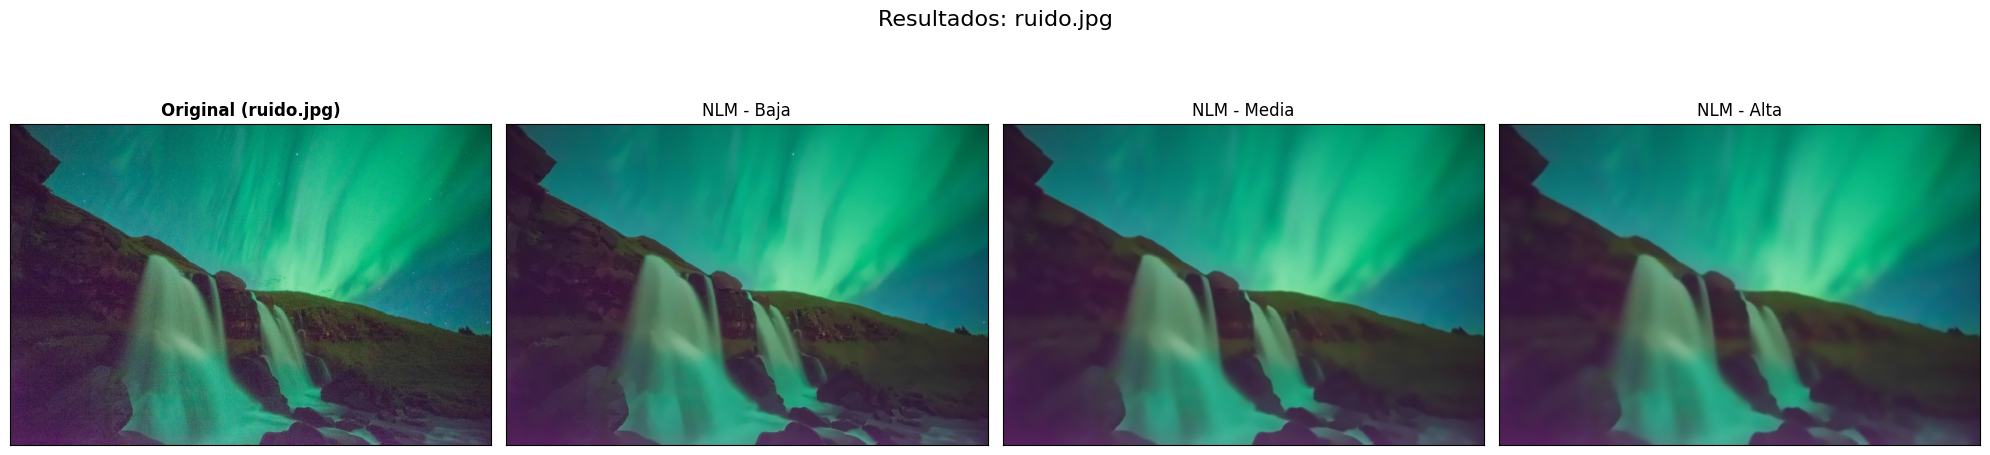

In [3]:
paths_ruido = ['../img/nlm_h5.png', '../img/nlm_h15.png', '../img/nlm_h30.png']
show_results_nlm('ruido.jpg', '../img/ruido.jpg', paths_ruido)

--- 
## Caso 2: Imagen `hombre.jpg`

In [4]:
# 1. Codificar imagen original
!python ../src/no_filter.py encode -i ../img/hombre.jpg -e ../img/hombre_encoded

# 2. Decodificar aplicando NLM (h=5, 15, 30)
!python ../src/NLM.py decode -i ../img/hombre_encoded.tif -o ../img/hombre_nlm_h5.png --h 5
!python ../src/NLM.py decode -i ../img/hombre_encoded.tif -o ../img/hombre_nlm_h15.png --h 15
!python ../src/NLM.py decode -i ../img/hombre_encoded.tif -o ../img/hombre_nlm_h30.png --h 30

main Namespace(debug=False, subparser_name='encode', entropy_image_codec='TIFF', original='../img/hombre.jpg', encoded='../img/hombre_encoded', func=<function encode at 0x0000020BBFA4F920>)


(INFO) entropy_image_coding: Written 975845 bytes in ../img/hombre_encoded.tif


main Namespace(debug=False, subparser_name='decode', h=5.0, template_window_size=7, search_window_size=21, entropy_image_codec='TIFF', encoded='../img/hombre_encoded.tif', decoded='../img/hombre_nlm_h5.png', func=<function decode at 0x000001CEF16E6660>)


(INFO) NLM: NLM filter strength (h)=5.0
(INFO) NLM: NLM template window size=7
(INFO) NLM: NLM search window size=21
(INFO) NLM: Aplicando denoising NLM a imagen en color


main Namespace(debug=False, subparser_name='decode', h=15.0, template_window_size=7, search_window_size=21, entropy_image_codec='TIFF', encoded='../img/hombre_encoded.tif', decoded='../img/hombre_nlm_h15.png', func=<function decode at 0x0000016430416660>)


(INFO) NLM: NLM filter strength (h)=15.0
(INFO) NLM: NLM template window size=7
(INFO) NLM: NLM search window size=21
(INFO) NLM: Aplicando denoising NLM a imagen en color


main Namespace(debug=False, subparser_name='decode', h=30.0, template_window_size=7, search_window_size=21, entropy_image_codec='TIFF', encoded='../img/hombre_encoded.tif', decoded='../img/hombre_nlm_h30.png', func=<function decode at 0x000001EBEA8C6660>)


(INFO) NLM: NLM filter strength (h)=30.0
(INFO) NLM: NLM template window size=7
(INFO) NLM: NLM search window size=21
(INFO) NLM: Aplicando denoising NLM a imagen en color


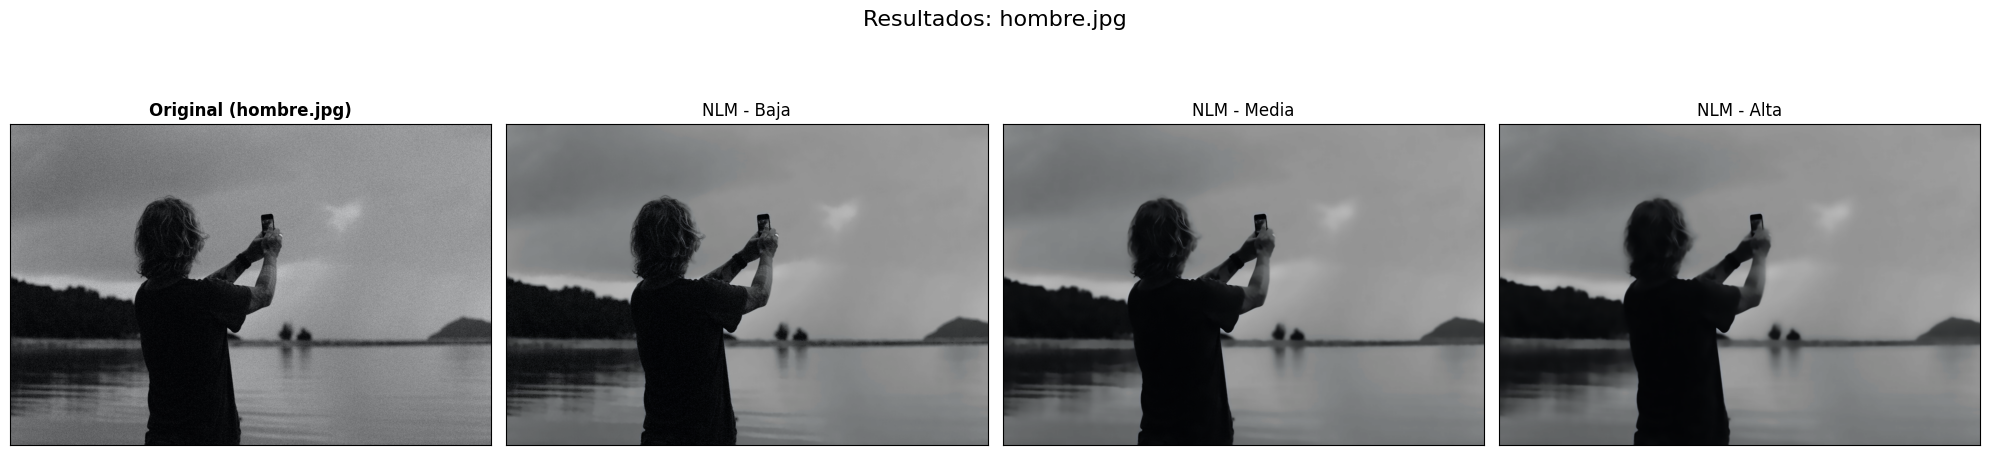

In [5]:
paths_hombre = ['../img/hombre_nlm_h5.png', '../img/hombre_nlm_h15.png', '../img/hombre_nlm_h30.png']
show_results_nlm('hombre.jpg', '../img/hombre.jpg', paths_hombre)